In [1]:
import scanpy as sc
import torch
import lightning.pytorch as pl
from torch import nn
from torch.optim import AdamW
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPAutoEncoder
from self_supervision.estimator.cellnet import EstimatorAutoEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import pandas as pd

# 1. 加载数据集
data_dir = '../../dataset/Xenium_breast_cancer_sample1_replicate1.h5ad'
adata = sc.read_h5ad(data_dir)


#data preprocessing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)


# 2. 设置 checkpoint 路径
ckpt_path = "../../sc_pretrained/Pretrained Models/GPMask.ckpt"

# 3. 模型参数
units_encoder = [512, 512, 256, 256, 64]
units_decoder = [256, 256, 512, 512]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 没有实际数据路径，可以设置为None

# 4. 加载预训练模型
estim.model = MLPAutoEncoder.load_from_checkpoint(
    ckpt_path,
    gene_dim=19331,  # 根据你的数据调整
    batch_size=128,  # 根据你的需要调整
    units_encoder=units_encoder, 
    units_decoder=units_decoder,
    masking_strategy="random",  # 假设模型使用了随机掩码
    masking_rate=0.5,  # 根据需要调整
)

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [2]:
# 添加分类层 (FC)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)
n_classes

20

In [3]:
var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
all_genes = var_df['feature_name'].tolist()

new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)

adata.var['gene_name']=adata.var.index
existing_genes = adata.var['gene_name']

In [4]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes

匹配的基因数量: 305
匹配的基因列表: {'gata3', 'ccl20', 'dnttip1', 'tigit', 'muc6', 'cd79a', 'cd3e', 'zeb2', 'hmga1', 'usp53', 'dsc2', 'ceacam6', 'krt6b', 'cldn5', 'hdc', 'lilra4', 'mybpc1', 'foxa1', 'slamf7', 'il7r', 'dst', 'krt14', 'aqp3', 'peli1', 'glipr1', 'cd68', 'fblim1', 'krt7', 'foxc2', 'klf5', 'slc25a37', 'cd4', 'avpr1a', 'cd69', 'rab30', 'aif1', 'klrb1', 'lum', 'ly86', 'elf3', 'tyrobp', 'mmrn2', 'ucp1', 'fgl2', 'ccr7', 'sec11c', 'tmem147', 'sqle', 'mlph', 'itgam', 'ankrd29', 'ankrd28', 's100a14', 'mzb1', 'cth', 'sfrp4', 'npm3', 'mmp1', 'trappc3', 'derl3', 'cd79b', 'medag', 'slamf1', 'krt16', 'apoc1', 'tcf4', 'rapgef3', 'sec24a', 'tifa', 'c1qc', 'adam9', 'fbln1', 'apobec3a', 'ramp2', 'igsf6', 'c6orf132', 'akr1c3', 'nostrin', 'pcolce', 'pdcd1', 'snai1', 'ltb', 'postn', 'adgre5', 'edn1', 'ccpg1', 'igf1', 's100a8', 'cd80', 'sdc4', 'ociad2', 'akr1c1', 'gzmk', 'lypd3', 'cldn4', 'egfl7', 'pdk4', 'adipoq', 'mnda', 'clecl1', 'map3k8', 'actg2', 'cav1', 'oprpn', 's100a4', 'zeb1', 'cd83', 'dusp2', 'dna

{'fam49a', 'kars', 'lars', 'nars', 'polr2j3', 'qars', 'trac', 'wars'}

In [5]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
dense_adata_X = adata.X.toarray()
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

Gene fam49a not found in all_genes list
Gene kars not found in all_genes list


Gene lars not found in all_genes list
Gene nars not found in all_genes list


Gene polr2j3 not found in all_genes list
Gene qars not found in all_genes list


Gene trac not found in all_genes list
Gene wars not found in all_genes list


In [6]:
# 使用 GPU 进行评估（如果可用）
estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)

# 5. 数据集划分（70% 训练，15% 验证，15% 测试）
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42

X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.15, random_state=random_seed)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


In [7]:
# 将训练数据转换为张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)
estim.model.to(device)

MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [8]:
# 6. 微调模型，仅微调 encoder 的最后两层，其他层参数冻结
for param in estim.model.encoder.parameters():
    param.requires_grad = False  # 冻结所有层

# 解冻最后两层
for param in list(estim.model.encoder.parameters())[-5:]:
    param.requires_grad = True

In [9]:
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [10]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 128  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 7. 微调模型
def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.encoder(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.encoder(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [11]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")

Epoch 1, Train Loss: 1.222064210893282, Validation Loss: 0.802108623049586
Validation loss improved to 0.802108623049586, resetting patience.


Epoch 2, Train Loss: 0.9603664391310905, Validation Loss: 0.7763314410514638
Validation loss improved to 0.7763314410514638, resetting patience.


Epoch 3, Train Loss: 0.9375725484621551, Validation Loss: 0.7580436577046583
Validation loss improved to 0.7580436577046583, resetting patience.


Epoch 4, Train Loss: 0.9232495703079082, Validation Loss: 0.756810568008326
Validation loss improved to 0.756810568008326, resetting patience.


Epoch 5, Train Loss: 0.914537516684314, Validation Loss: 0.746413577934207
Validation loss improved to 0.746413577934207, resetting patience.


Epoch 6, Train Loss: 0.9065496225502496, Validation Loss: 0.7771506708890653
No improvement in validation loss. Patience counter: 1/20


Epoch 7, Train Loss: 0.9009958260848892, Validation Loss: 0.7389271991507051
Validation loss improved to 0.7389271991507051, resetting patience.


Epoch 8, Train Loss: 0.9002108372634273, Validation Loss: 0.7408680092864836
No improvement in validation loss. Patience counter: 1/20


Epoch 9, Train Loss: 0.8930807410372109, Validation Loss: 0.7418447557439659
No improvement in validation loss. Patience counter: 2/20


Epoch 10, Train Loss: 0.8914795010178177, Validation Loss: 0.7238201583702553
Validation loss improved to 0.7238201583702553, resetting patience.


Epoch 11, Train Loss: 0.8864677217920881, Validation Loss: 0.7464419875653262
No improvement in validation loss. Patience counter: 1/20


Epoch 12, Train Loss: 0.8859254492523884, Validation Loss: 0.7354728679366523
No improvement in validation loss. Patience counter: 2/20


Epoch 13, Train Loss: 0.8806117267260625, Validation Loss: 0.7329704280432106
No improvement in validation loss. Patience counter: 3/20


Epoch 14, Train Loss: 0.8792144073120649, Validation Loss: 0.7013974943136806
Validation loss improved to 0.7013974943136806, resetting patience.


Epoch 15, Train Loss: 0.8772418111367942, Validation Loss: 0.7288460764788129
No improvement in validation loss. Patience counter: 1/20


Epoch 16, Train Loss: 0.8739971843809863, Validation Loss: 0.7095516644758622
No improvement in validation loss. Patience counter: 2/20


Epoch 17, Train Loss: 0.8744757833823659, Validation Loss: 0.7092254473473215
No improvement in validation loss. Patience counter: 3/20


Epoch 18, Train Loss: 0.8738507843355208, Validation Loss: 0.7122684537154164
No improvement in validation loss. Patience counter: 4/20


Epoch 19, Train Loss: 0.8693631119977415, Validation Loss: 0.7095398993661561
No improvement in validation loss. Patience counter: 5/20


Epoch 20, Train Loss: 0.8694756751096846, Validation Loss: 0.6993295035991572
Validation loss improved to 0.6993295035991572, resetting patience.


Epoch 21, Train Loss: 0.8666246171740405, Validation Loss: 0.720382402390998
No improvement in validation loss. Patience counter: 1/20


Epoch 22, Train Loss: 0.8668755702593228, Validation Loss: 0.7053127208639522
No improvement in validation loss. Patience counter: 2/20


Epoch 23, Train Loss: 0.8636653604460698, Validation Loss: 0.7022126466792247
No improvement in validation loss. Patience counter: 3/20


Epoch 24, Train Loss: 0.8631645357946425, Validation Loss: 0.7003747690752679
No improvement in validation loss. Patience counter: 4/20


Epoch 25, Train Loss: 0.8646443540104594, Validation Loss: 0.6991111024987274
Validation loss improved to 0.6991111024987274, resetting patience.


Epoch 26, Train Loss: 0.8644004656338744, Validation Loss: 0.6918096227694284
Validation loss improved to 0.6918096227694284, resetting patience.


Epoch 27, Train Loss: 0.8617001699855904, Validation Loss: 0.7046500559385658
No improvement in validation loss. Patience counter: 1/20


Epoch 28, Train Loss: 0.8590877306747021, Validation Loss: 0.6964588687202047
No improvement in validation loss. Patience counter: 2/20


Epoch 29, Train Loss: 0.8609501661688155, Validation Loss: 0.7270147531165689
No improvement in validation loss. Patience counter: 3/20


Epoch 30, Train Loss: 0.8601898306205642, Validation Loss: 0.7080470898429755
No improvement in validation loss. Patience counter: 4/20


Epoch 31, Train Loss: 0.8591725670434291, Validation Loss: 0.7155556578926628
No improvement in validation loss. Patience counter: 5/20


Epoch 32, Train Loss: 0.8557117588509662, Validation Loss: 0.6960349028485681
No improvement in validation loss. Patience counter: 6/20


Epoch 33, Train Loss: 0.8566579601538726, Validation Loss: 0.696073659785508
No improvement in validation loss. Patience counter: 7/20


Epoch 34, Train Loss: 0.8544615480505043, Validation Loss: 0.7066138436649051
No improvement in validation loss. Patience counter: 8/20


Epoch 35, Train Loss: 0.8551735761768158, Validation Loss: 0.698061422345602
No improvement in validation loss. Patience counter: 9/20


Epoch 36, Train Loss: 0.8565319179190011, Validation Loss: 0.7015066381335864
No improvement in validation loss. Patience counter: 10/20


Epoch 37, Train Loss: 0.8533727149428365, Validation Loss: 0.699256269459797
No improvement in validation loss. Patience counter: 11/20


Epoch 38, Train Loss: 0.8549513862932949, Validation Loss: 0.6928739906265046
No improvement in validation loss. Patience counter: 12/20


Epoch 39, Train Loss: 0.8524768325238447, Validation Loss: 0.7346797842664767
No improvement in validation loss. Patience counter: 13/20


Epoch 40, Train Loss: 0.8542502967230895, Validation Loss: 0.6943680998032469
No improvement in validation loss. Patience counter: 14/20


Epoch 41, Train Loss: 0.8579458755345646, Validation Loss: 0.7028585200382368
No improvement in validation loss. Patience counter: 15/20


Epoch 42, Train Loss: 0.8550801997221114, Validation Loss: 0.6991115676872621
No improvement in validation loss. Patience counter: 16/20


Epoch 43, Train Loss: 0.8515677898797595, Validation Loss: 0.6976399724253544
No improvement in validation loss. Patience counter: 17/20


Epoch 44, Train Loss: 0.8551354238150686, Validation Loss: 0.6911308393260549
Validation loss improved to 0.6911308393260549, resetting patience.


Epoch 45, Train Loss: 0.852332853348946, Validation Loss: 0.6887079781384637
Validation loss improved to 0.6887079781384637, resetting patience.


Epoch 46, Train Loss: 0.8512197723835382, Validation Loss: 0.6859667397997706
Validation loss improved to 0.6859667397997706, resetting patience.


Epoch 47, Train Loss: 0.8491074276645718, Validation Loss: 0.6814767070833196
Validation loss improved to 0.6814767070833196, resetting patience.


Epoch 48, Train Loss: 0.8510245383435086, Validation Loss: 0.7155114330616094
No improvement in validation loss. Patience counter: 1/20


Epoch 49, Train Loss: 0.8480563115710007, Validation Loss: 0.6989329968612206
No improvement in validation loss. Patience counter: 2/20


Epoch 50, Train Loss: 0.8550120427847429, Validation Loss: 0.6953707839631792
No improvement in validation loss. Patience counter: 3/20


Epoch 51, Train Loss: 0.8492472317223975, Validation Loss: 0.6910271269415841
No improvement in validation loss. Patience counter: 4/20


Epoch 52, Train Loss: 0.8523200357531671, Validation Loss: 0.7114279276223352
No improvement in validation loss. Patience counter: 5/20


Epoch 53, Train Loss: 0.8510974967012218, Validation Loss: 0.6885782000679656
No improvement in validation loss. Patience counter: 6/20


Epoch 54, Train Loss: 0.8488167605498778, Validation Loss: 0.7010165903774009
No improvement in validation loss. Patience counter: 7/20


Epoch 55, Train Loss: 0.8490165875238531, Validation Loss: 0.6912659368841781
No improvement in validation loss. Patience counter: 8/20


Epoch 56, Train Loss: 0.8453160068568062, Validation Loss: 0.7000742843610986
No improvement in validation loss. Patience counter: 9/20


Epoch 57, Train Loss: 0.8482642947069181, Validation Loss: 0.6962774639504815
No improvement in validation loss. Patience counter: 10/20


Epoch 58, Train Loss: 0.8484733143013806, Validation Loss: 0.6999002207959364
No improvement in validation loss. Patience counter: 11/20


Epoch 59, Train Loss: 0.8458288874891069, Validation Loss: 0.6893558099790273
No improvement in validation loss. Patience counter: 12/20


Epoch 60, Train Loss: 0.8521587238981833, Validation Loss: 0.7072681445760776
No improvement in validation loss. Patience counter: 13/20


Epoch 61, Train Loss: 0.8480905982014401, Validation Loss: 0.685351155433558
No improvement in validation loss. Patience counter: 14/20


Epoch 62, Train Loss: 0.8487697316410755, Validation Loss: 0.6827365805957523
No improvement in validation loss. Patience counter: 15/20


Epoch 63, Train Loss: 0.84881448557434, Validation Loss: 0.705964292063931
No improvement in validation loss. Patience counter: 16/20


Epoch 64, Train Loss: 0.8486294026987745, Validation Loss: 0.6800487210907912
Validation loss improved to 0.6800487210907912, resetting patience.


Epoch 65, Train Loss: 0.848033530000508, Validation Loss: 0.6951852738857269
No improvement in validation loss. Patience counter: 1/20


Epoch 66, Train Loss: 0.8485522416941741, Validation Loss: 0.6982547289828964
No improvement in validation loss. Patience counter: 2/20


Epoch 67, Train Loss: 0.849467457314722, Validation Loss: 0.6844555747690539
No improvement in validation loss. Patience counter: 3/20


Epoch 68, Train Loss: 0.8461139819590874, Validation Loss: 0.6911648041403233
No improvement in validation loss. Patience counter: 4/20


Epoch 69, Train Loss: 0.849877718422148, Validation Loss: 0.7001537585318997
No improvement in validation loss. Patience counter: 5/20


Epoch 70, Train Loss: 0.846007206406209, Validation Loss: 0.6894419395984127
No improvement in validation loss. Patience counter: 6/20


Epoch 71, Train Loss: 0.8459036355444549, Validation Loss: 0.6949361399345592
No improvement in validation loss. Patience counter: 7/20


Epoch 72, Train Loss: 0.8474810175711293, Validation Loss: 0.6826661109621754
No improvement in validation loss. Patience counter: 8/20


Epoch 73, Train Loss: 0.8468676252952069, Validation Loss: 0.6925090536248261
No improvement in validation loss. Patience counter: 9/20


Epoch 74, Train Loss: 0.8472577672378689, Validation Loss: 0.6945230733924711
No improvement in validation loss. Patience counter: 10/20


Epoch 75, Train Loss: 0.8447427357463795, Validation Loss: 0.687835780345849
No improvement in validation loss. Patience counter: 11/20


Epoch 76, Train Loss: 0.8462127419858197, Validation Loss: 0.693702115927856
No improvement in validation loss. Patience counter: 12/20


Epoch 77, Train Loss: 0.8461886937192322, Validation Loss: 0.6941684404302975
No improvement in validation loss. Patience counter: 13/20


Epoch 78, Train Loss: 0.8446633910561439, Validation Loss: 0.6905746953136425
No improvement in validation loss. Patience counter: 14/20


Epoch 79, Train Loss: 0.84684880697909, Validation Loss: 0.6818818462076526
No improvement in validation loss. Patience counter: 15/20


Epoch 80, Train Loss: 0.8454378186552612, Validation Loss: 0.6832544623595204
No improvement in validation loss. Patience counter: 16/20


Epoch 81, Train Loss: 0.8450388783073634, Validation Loss: 0.67839188533386
Validation loss improved to 0.67839188533386, resetting patience.


Epoch 82, Train Loss: 0.8433159261227693, Validation Loss: 0.6871806594926089
No improvement in validation loss. Patience counter: 1/20


Epoch 83, Train Loss: 0.844712789087254, Validation Loss: 0.694459741036904
No improvement in validation loss. Patience counter: 2/20


Epoch 84, Train Loss: 0.8463851851056085, Validation Loss: 0.6911297479861884
No improvement in validation loss. Patience counter: 3/20


Epoch 85, Train Loss: 0.8476873529113196, Validation Loss: 0.6812643319519643
No improvement in validation loss. Patience counter: 4/20


Epoch 86, Train Loss: 0.8430503723668117, Validation Loss: 0.6970311031123708
No improvement in validation loss. Patience counter: 5/20


Epoch 87, Train Loss: 0.8441610903781483, Validation Loss: 0.6947241886920735
No improvement in validation loss. Patience counter: 6/20


Epoch 88, Train Loss: 0.8446548711630254, Validation Loss: 0.6944489353501857
No improvement in validation loss. Patience counter: 7/20


Epoch 89, Train Loss: 0.8469008134600903, Validation Loss: 0.679727694709894
No improvement in validation loss. Patience counter: 8/20


Epoch 90, Train Loss: 0.8465110516106641, Validation Loss: 0.6927574387359136
No improvement in validation loss. Patience counter: 9/20


Epoch 91, Train Loss: 0.8457250082155199, Validation Loss: 0.6896473986243233
No improvement in validation loss. Patience counter: 10/20


Epoch 92, Train Loss: 0.8457179939565056, Validation Loss: 0.6796644042591153
No improvement in validation loss. Patience counter: 11/20


Epoch 93, Train Loss: 0.8467655493543039, Validation Loss: 0.684885968714196
No improvement in validation loss. Patience counter: 12/20


Epoch 94, Train Loss: 0.8458761705292596, Validation Loss: 0.6875311027323534
No improvement in validation loss. Patience counter: 13/20


Epoch 95, Train Loss: 0.8444797907649562, Validation Loss: 0.6889833549255042
No improvement in validation loss. Patience counter: 14/20


Epoch 96, Train Loss: 0.8441572198421088, Validation Loss: 0.6773020308937518
Validation loss improved to 0.6773020308937518, resetting patience.


Epoch 97, Train Loss: 0.8456805319827626, Validation Loss: 0.6793973636506173
No improvement in validation loss. Patience counter: 1/20


Epoch 98, Train Loss: 0.8455880569996138, Validation Loss: 0.6882582078427832
No improvement in validation loss. Patience counter: 2/20


Epoch 99, Train Loss: 0.8462173736173343, Validation Loss: 0.6959038447910154
No improvement in validation loss. Patience counter: 3/20


Epoch 100, Train Loss: 0.8475051475506202, Validation Loss: 0.6989403648424874
No improvement in validation loss. Patience counter: 4/20


Epoch 101, Train Loss: 0.8472564075637228, Validation Loss: 0.681457784726535
No improvement in validation loss. Patience counter: 5/20


Epoch 102, Train Loss: 0.8466883408218168, Validation Loss: 0.6909640392071099
No improvement in validation loss. Patience counter: 6/20


Epoch 103, Train Loss: 0.8437581046084692, Validation Loss: 0.6868857526537125
No improvement in validation loss. Patience counter: 7/20


Epoch 104, Train Loss: 0.8443552937382967, Validation Loss: 0.7241664410847698
No improvement in validation loss. Patience counter: 8/20


Epoch 105, Train Loss: 0.8445867441578369, Validation Loss: 0.687954947276769
No improvement in validation loss. Patience counter: 9/20


Epoch 106, Train Loss: 0.8428424144557358, Validation Loss: 0.709928219996128
No improvement in validation loss. Patience counter: 10/20


Epoch 107, Train Loss: 0.8445889523216322, Validation Loss: 0.7077094255970214
No improvement in validation loss. Patience counter: 11/20


Epoch 108, Train Loss: 0.845997440594214, Validation Loss: 0.6867470842630125
No improvement in validation loss. Patience counter: 12/20


Epoch 109, Train Loss: 0.8451126610012096, Validation Loss: 0.6921727413755988
No improvement in validation loss. Patience counter: 13/20


Epoch 110, Train Loss: 0.8496409483854547, Validation Loss: 0.7018193132078587
No improvement in validation loss. Patience counter: 14/20


Epoch 111, Train Loss: 0.8478883315275437, Validation Loss: 0.683915951832902
No improvement in validation loss. Patience counter: 15/20


Epoch 112, Train Loss: 0.8438938560049518, Validation Loss: 0.6843444582471992
No improvement in validation loss. Patience counter: 16/20


Epoch 113, Train Loss: 0.8428495639939194, Validation Loss: 0.6847355267420638
No improvement in validation loss. Patience counter: 17/20


Epoch 114, Train Loss: 0.8483182837241096, Validation Loss: 0.7023571463405783
No improvement in validation loss. Patience counter: 18/20


Epoch 115, Train Loss: 0.8450372333360393, Validation Loss: 0.6942057919683795
No improvement in validation loss. Patience counter: 19/20


Epoch 116, Train Loss: 0.8443135045842148, Validation Loss: 0.6799512747580629
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training at epoch 116.
Loaded best model weights based on validation loss.


In [12]:
import os

# 定义保存路径
save_dir = './xenium_best_model_ckpt'
save_path = os.path.join(save_dir, f'GP_FT_Xenium_breast_cancer_sample1_replicate1_best_model_{random_seed}.ckpt')

# 如果目录不存在，则创建
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存模型
torch.save(best_model_weights, save_path)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


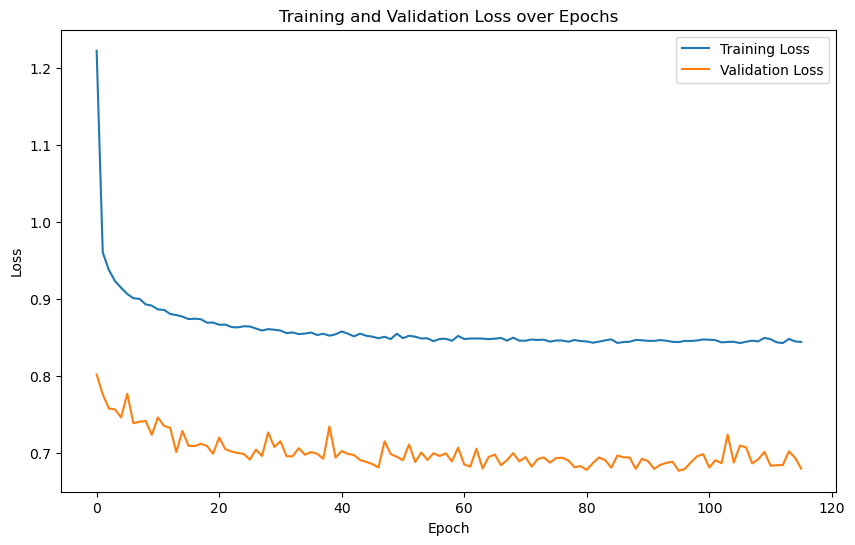

In [13]:
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，而不是 matplotlib

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig(f'../loss_curve_fig/xenium_breast_cancer_gp_mask_finetune_full_loss_curve{random_seed}.png', dpi=400)  # 保存图像为png格式，400 dpi
plt.savefig(f'../loss_curve_fig/xenium_breast_cancer_gp_mask_finetune_full_loss_curve{random_seed}.eps', format='eps', dpi=400)  # 保存图像为png格式，400 dpi

plt.show()

In [14]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.encoder(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.encoder(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [15]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.7614733579687686
Weighted F1 Score: 0.7542796017079462
Macro F1 Score: 0.6167320884649969
Random Guess Accuracy: 0.1320247177116093
                         precision    recall  f1-score   support

                B_Cells       0.79      0.86      0.82       772
           CD4+_T_Cells       0.59      0.72      0.65      1286
           CD8+_T_Cells       0.63      0.64      0.64      1026
                 DCIS_1       0.75      0.83      0.79      1937
                 DCIS_2       0.70      0.71      0.70      1746
            Endothelial       0.84      0.86      0.85      1348
              IRF7+_DCs       0.79      0.78      0.79        74
         Invasive_Tumor       0.85      0.88      0.86      5230
             LAMP3+_DCs       0.65      0.35      0.45        49
          Macrophages_1       0.65      0.64      0.64      1692
          Macrophages_2       0.49      0.38      0.43       223
             Mast_Cells       0.72      0.64      0.68    

In [16]:
with torch.no_grad():
    new_data_tensor = torch.tensor(new_data).float().to(device)
    SSL_embeddings = estim.model.encoder(new_data_tensor).detach().cpu().numpy()
new_adata = sc.read_h5ad(data_dir)
new_adata.obsm[f'SSL_GP_FT_{random_seed}'] = SSL_embeddings
new_adata.uns[f'GP_FT_y_test_{random_seed}'] = y_test
new_adata.uns[f'GP_FT_predictions_{random_seed}'] = predictions
new_adata.uns[f'GP_FT_target_names_{random_seed}'] = label_encoder.classes_
new_adata.uns[f'GP_FT_train_loss_{random_seed}'] = train_losses
new_adata.uns[f'GP_FT_val_loss_{random_seed}'] = val_losses
new_adata.write_h5ad(data_dir)

In [17]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "Xenium_breast_cancer_sample1_replicate1_GP_mask_fine_tune_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicor_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['xenium_breast_cancer_sample1_replicate1'],
    'method': [re.search(r'replicate1_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micor_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micor_f1
1.222	0.802	96	0.677	0.617	0.754	0.761
